Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

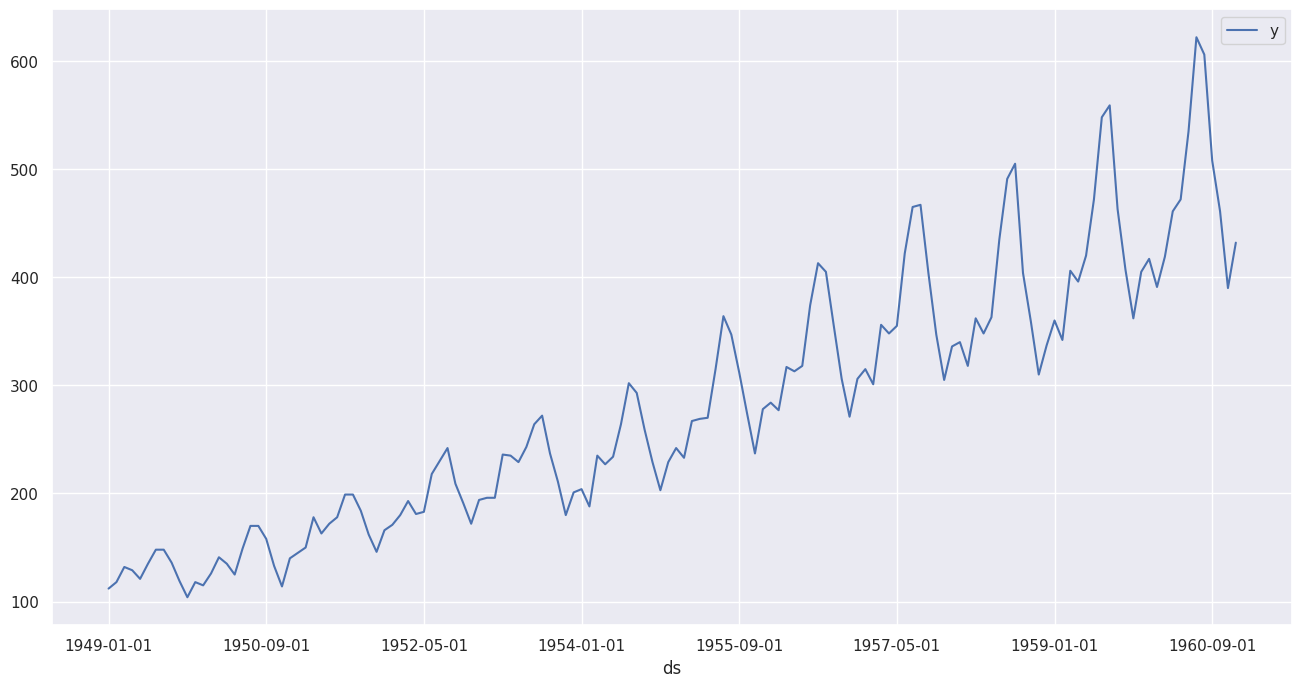

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Customized model request
model_request = {
    "params": {
      "changepoints_range": 0.2,
      "epochs": 2,
      "growth": "off"
    },
    "metrics": [],
    "type": "neuralprophet",
}

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('np_url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 375 ms


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'status': 'ok',
 'metrics': {},
 'model': 'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY25ldXJhbHByb3BoZXQuZm9yZWNhc3RlcgpOZXVyYWxQcm9waGV0CnEAKYFxAX1xAihYBgAAAGNvbmZpZ3EDfXEEKFgGAAAAZ3Jvd3RocQVYAwAAAG9mZnEGWAwAAABjaGFuZ2Vwb2ludHNxB05YDgAAAG5fY2hhbmdlcG9pbnRzcQhLClgSAAAAY2hhbmdlcG9pbnRzX3JhbmdlcQlHP8mZmZmZmZpYCQAAAHRyZW5kX3JlZ3EKSwBYEwAAAHRyZW5kX3JlZ190aHJlc2hvbGRxC4lYEgAAAHRyZW5kX2dsb2JhbF9sb2NhbHEMWAYAAABnbG9iYWxxDVgSAAAAeWVhcmx5X3NlYXNvbmFsaXR5cQ5YBAAAAGF1dG9xD1gSAAAAd2Vla2x5X3NlYXNvbmFsaXR5cRBoD1gRAAAAZGFpbHlfc2Vhc29uYWxpdHlxEWgPWBAAAABzZWFzb25hbGl0eV9tb2RlcRJYCAAAAGFkZGl0aXZlcRNYDwAAAHNlYXNvbmFsaXR5X3JlZ3EUSwBYEwAAAHNlYXNvbl9nbG9iYWxfbG9jYWxxFWgNWAsAAABuX2ZvcmVjYXN0c3EWSwFYBgAAAG5fbGFnc3EXSwBYCQAAAGFyX2xheWVyc3EYXXEZWAYAAABhcl9yZWdxGk5YEQAAAGxhZ2dlZF9yZWdfbGF5ZXJzcRtdcRxYDQAAAGxlYXJuaW5nX3JhdGVxHU5YBgAAAGVwb2Noc3EeSwJYCgAAAGJhdGNoX3NpemVxH05YCQAAAGxvc3NfZnVuY3EgWAUAAABIdWJlcnEhWAkAAABvcHRpbWl6ZXJxIlgFAAAAQWRhbVdxI1gUAAAAbmV3ZXJfc2FtcGxl

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 19.9 ms, sys: 3.96 ms, total: 23.8 ms
Wall time: 324 ms


In [28]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'status': 'ok',
 'forecast': {'ds': {'0': '1961-01-01T00:00:00',
   '1': '1961-02-01T00:00:00',
   '2': '1961-03-01T00:00:00',
   '3': '1961-04-01T00:00:00',
   '4': '1961-05-01T00:00:00',
   '5': '1961-06-01T00:00:00',
   '6': '1961-07-01T00:00:00',
   '7': '1961-08-01T00:00:00',
   '8': '1961-09-01T00:00:00',
   '9': '1961-10-01T00:00:00',
   '10': '1961-11-01T00:00:00',
   '11': '1961-12-01T00:00:00',
   '12': '1962-01-01T00:00:00',
   '13': '1962-02-01T00:00:00',
   '14': '1962-03-01T00:00:00',
   '15': '1962-04-01T00:00:00',
   '16': '1962-05-01T00:00:00',
   '17': '1962-06-01T00:00:00',
   '18': '1962-07-01T00:00:00',
   '19': '1962-08-01T00:00:00',
   '20': '1962-09-01T00:00:00',
   '21': '1962-10-01T00:00:00',
   '22': '1962-11-01T00:00:00',
   '23': '1962-12-01T00:00:00'},
  'yhat1': {'0': 650.1071166992188,
   '1': 361.6196594238281,
   '2': 726.9364013671875,
   '3': 510.84661865234375,
   '4': 822.7584838867188,
   '5': 358.0246276855469,
   '6': 734.4177856445312,
   '7':

Combine forecast dates and output

In [29]:
forecast = forecast_json_out['forecast']

forecast_ds = forecast['ds']
forecast_yhat = forecast['yhat1']

forecast_df = pd.DataFrame(
    data={
        'ds': forecast_ds,
        'y': forecast_yhat,
    },
    columns=[time_col, target_col],
)

In [30]:
forecast_df.shape

(24, 2)

In [31]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [32]:
forecast_df.head()

,ds,y
0,1961-01-01T00:00:00,650.107117
1,1961-02-01T00:00:00,361.619659
2,1961-03-01T00:00:00,726.936401
3,1961-04-01T00:00:00,510.846619
4,1961-05-01T00:00:00,822.758484


In [33]:
forecast_df.tail()

,ds,y
19,1962-08-01T00:00:00,321.936981
20,1962-09-01T00:00:00,557.362732
21,1962-10-01T00:00:00,638.648376
22,1962-11-01T00:00:00,649.978882
23,1962-12-01T00:00:00,446.458679


Plot train and forecast side-by-side

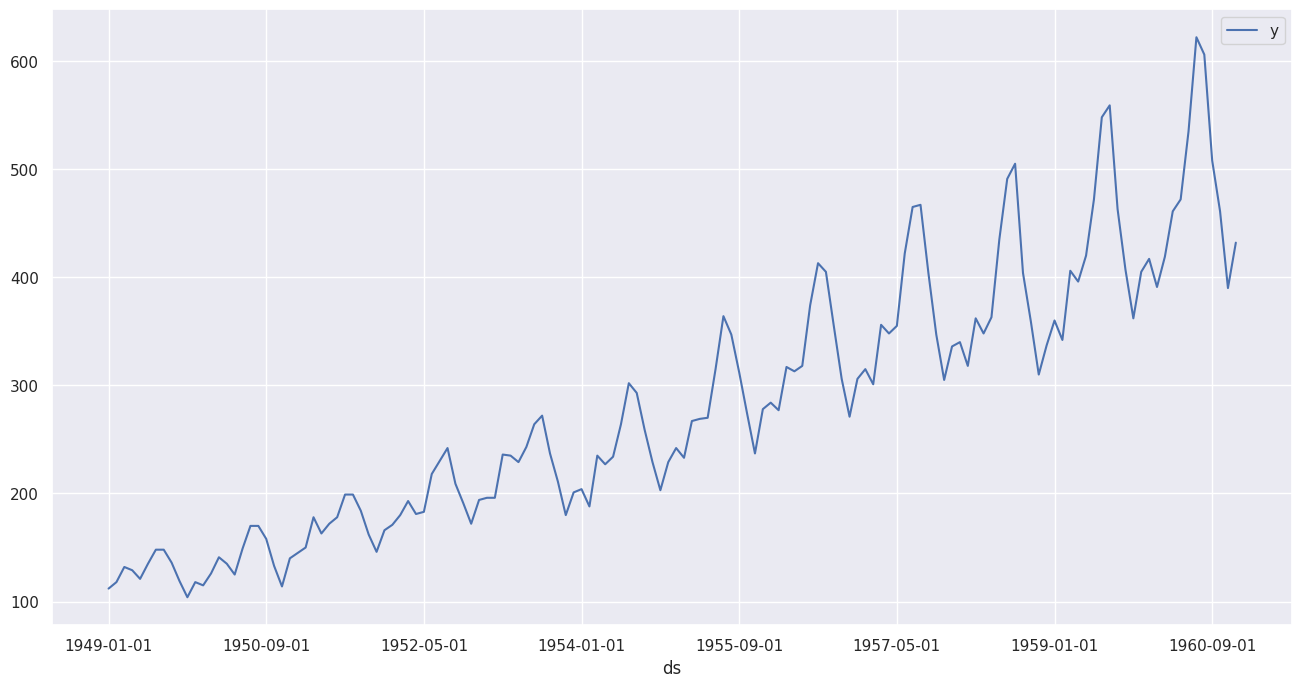

In [34]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

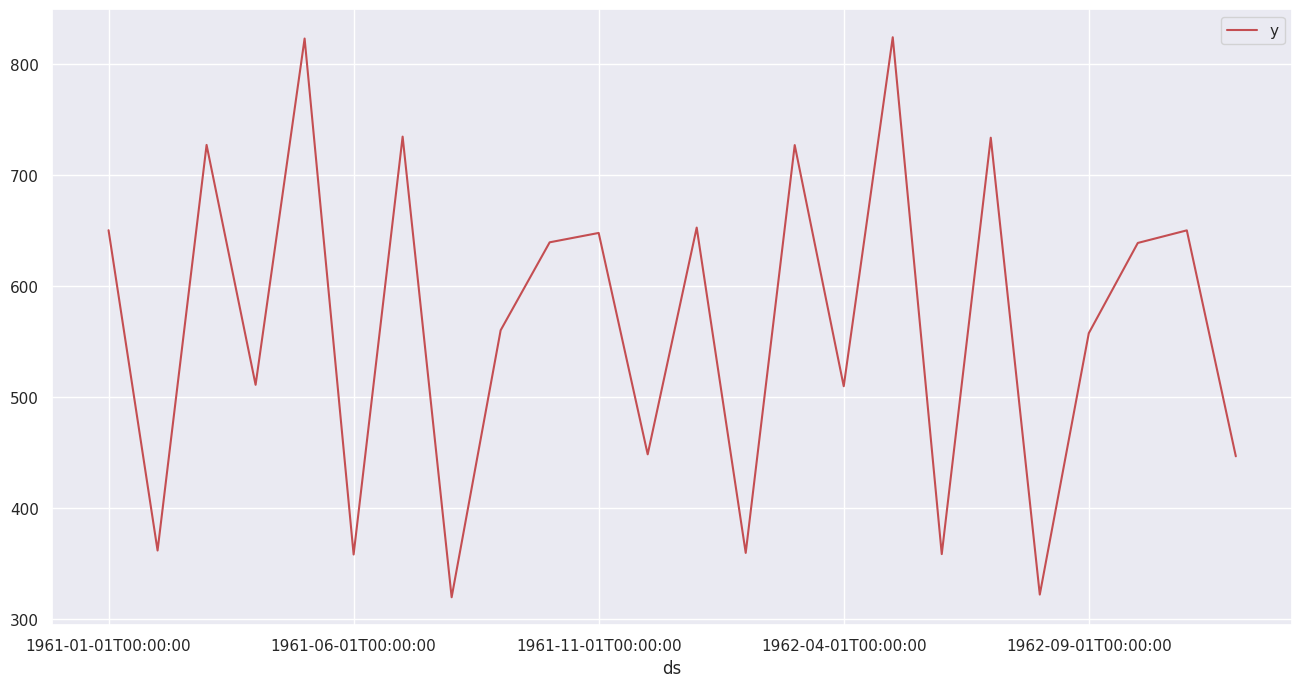

In [35]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [36]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [37]:
df.shape

(168, 3)

In [38]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [39]:
df.tail()

,ds,y,color
163,1962-08-01T00:00:00,321.936981,r
164,1962-09-01T00:00:00,557.362732,r
165,1962-10-01T00:00:00,638.648376,r
166,1962-11-01T00:00:00,649.978882,r
167,1962-12-01T00:00:00,446.458679,r


Plot combined train and test sets with the vertical black line as the cut-off

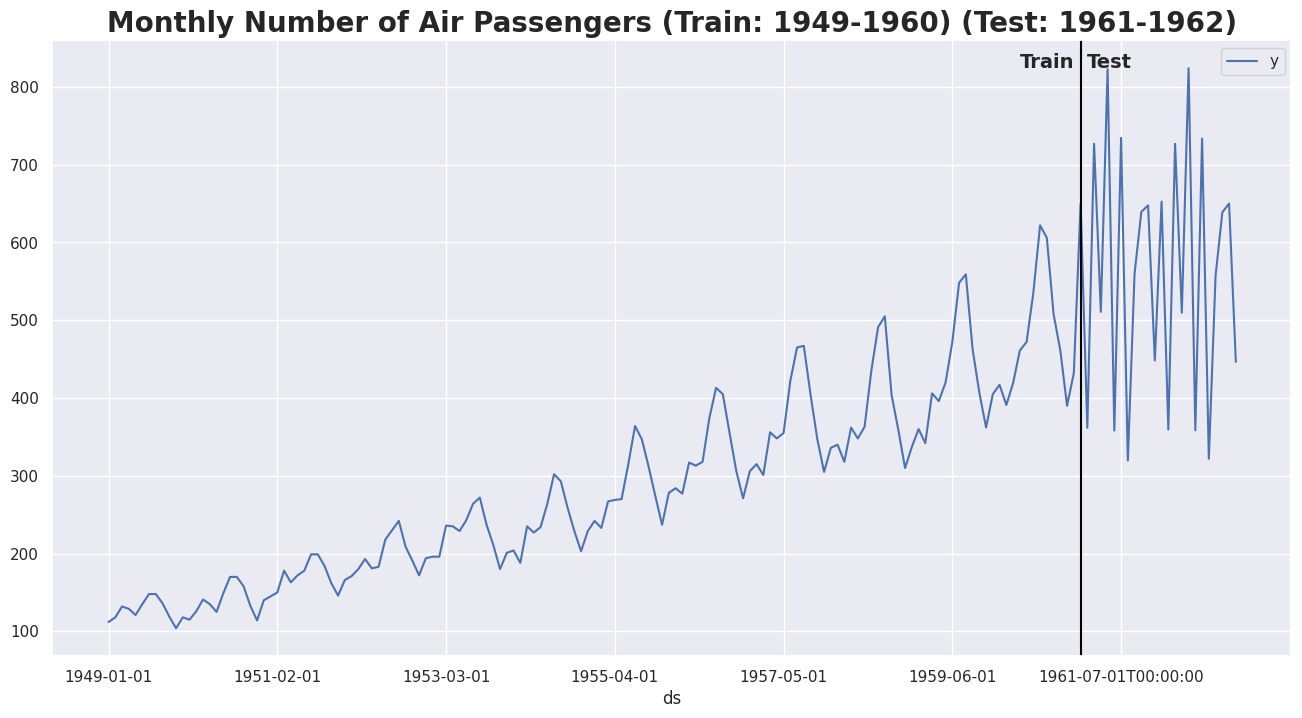

In [40]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();